In [1]:
import pandas as pd
import numpy as np
house=pd.read_csv("G:\minor_project\House\\house.csv")
house.rename(columns={'No. of Bedrooms':'No_of_Bedrooms',"Children'splayarea":'Childrens_playarea'},inplace=True)
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26456 entries, 0 to 26455
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   City                 26456 non-null  object
 1   Price                26456 non-null  int64 
 2   Area                 26456 non-null  int64 
 3   Location             26456 non-null  object
 4   No_of_Bedrooms       26456 non-null  int64 
 5   Resale               26456 non-null  int64 
 6   MaintenanceStaff     26456 non-null  int64 
 7   Gymnasium            26456 non-null  int64 
 8   SwimmingPool         26456 non-null  int64 
 9   LandscapedGardens    26456 non-null  int64 
 10  JoggingTrack         26456 non-null  int64 
 11  RainWaterHarvesting  26456 non-null  int64 
 12  IndoorGames          26456 non-null  int64 
 13  ShoppingMall         26456 non-null  int64 
 14  Intercom             26456 non-null  int64 
 15  SportsFacility       26456 non-null  int64 
 16  ATM 

In [4]:

house.drop(['City',
       'MaintenanceStaff', 'Gymnasium', 'SwimmingPool', 'LandscapedGardens',
       'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames', 'ShoppingMall',
       'Intercom', 'SportsFacility', 'ATM', 'ClubHouse', 'School',
       '24X7Security', 'PowerBackup', 'CarParking', 'StaffQuarter',
       'Cafeteria', 'MultipurposeRoom', 'Hospital', 'WashingMachine',
       'Gasconnection', 'AC', 'Wifi', 'Childrens_playarea', 'LiftAvailable',
       'BED', 'VaastuCompliant', 'Microwave', 'GolfCourse', 'TV',
       'DiningTable', 'Sofa', 'Wardrobe', 'Refrigerator'],axis=1,inplace=True)


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26456 entries, 0 to 26455
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Price           26456 non-null  int64 
 1   Area            26456 non-null  int64 
 2   Location        26456 non-null  object
 3   No_of_Bedrooms  26456 non-null  int64 
 4   Resale          26456 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 930.2+ KB


array([[<AxesSubplot:xlabel='Price', ylabel='Price'>,
        <AxesSubplot:xlabel='Area', ylabel='Price'>,
        <AxesSubplot:xlabel='No_of_Bedrooms', ylabel='Price'>,
        <AxesSubplot:xlabel='Resale', ylabel='Price'>],
       [<AxesSubplot:xlabel='Price', ylabel='Area'>,
        <AxesSubplot:xlabel='Area', ylabel='Area'>,
        <AxesSubplot:xlabel='No_of_Bedrooms', ylabel='Area'>,
        <AxesSubplot:xlabel='Resale', ylabel='Area'>],
       [<AxesSubplot:xlabel='Price', ylabel='No_of_Bedrooms'>,
        <AxesSubplot:xlabel='Area', ylabel='No_of_Bedrooms'>,
        <AxesSubplot:xlabel='No_of_Bedrooms', ylabel='No_of_Bedrooms'>,
        <AxesSubplot:xlabel='Resale', ylabel='No_of_Bedrooms'>],
       [<AxesSubplot:xlabel='Price', ylabel='Resale'>,
        <AxesSubplot:xlabel='Area', ylabel='Resale'>,
        <AxesSubplot:xlabel='No_of_Bedrooms', ylabel='Resale'>,
        <AxesSubplot:xlabel='Resale', ylabel='Resale'>]], dtype=object)

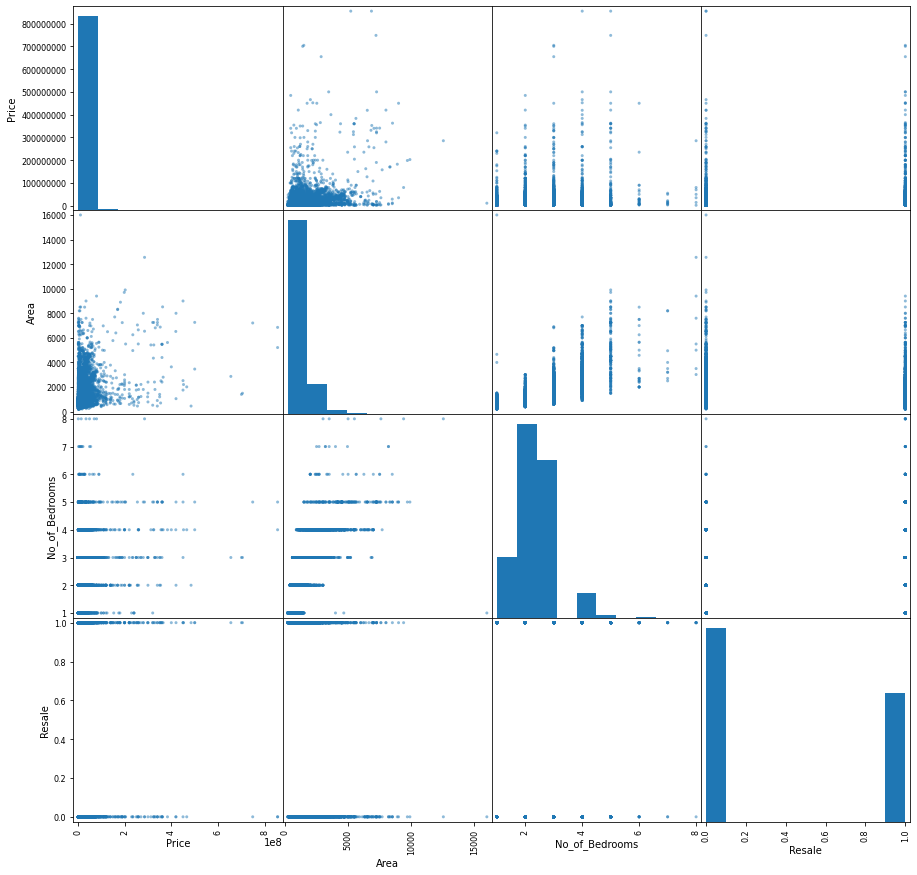

In [60]:
from pandas.plotting import scatter_matrix
attributes= ['Price','Area','No_of_Bedrooms','Resale']
scatter_matrix(house[attributes],figsize=(15,15))

In [47]:
house['No_of_Bedrooms'].value_counts()
house=house[house['No_of_Bedrooms']<5]

In [49]:
house['priceperarea']=house['Price']/house['Area']
house['Price_per_Bedroom']=house['Price']/house['No_of_Bedrooms']
def remove_outliers_sqft(df):
    df_output= pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        m = np.mean(subdf.priceperarea)
        st = np.std(subdf.priceperarea)
        gen_df=subdf[(subdf.priceperarea > (m-st)) & (subdf.priceperarea <= (m+st))]
        df_output = pd.concat([df_output, gen_df], ignore_index =True) 
    return df_output

house_train= remove_outliers_sqft(house)

In [50]:
def bhk_outlier_remover(df): 
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('No_of_Bedrooms'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.Price_per_Bedroom),
                'std': np.std(bhk_df.Price_per_Bedroom),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('No_of_Bedrooms'): 
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.Price_per_Bedroom<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

house_train=bhk_outlier_remover(house_train)

In [51]:
locationcount=house_train['Location'].value_counts()
locationcount=locationcount[locationcount<15].index
for i in locationcount:
    house_train=house_train[house_train['Location']!=i]

In [53]:
house_train.drop(['priceperarea','Price_per_Bedroom'],axis=1,inplace=True)
X=house_train.drop(columns=['Price'])
y=house_train['Price']

from sklearn.model_selection import train_test_split
Xtrain_set, Xtest_set, ytrain_set, ytest_set = train_test_split(X,y, test_size=0.2, random_state=42,stratify=X['Location'])

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
column_trans=make_column_transformer((OneHotEncoder(sparse=False),['Location']),remainder='passthrough')
scaler=StandardScaler()
lr=RandomForestRegressor()
pipe=make_pipeline(column_trans,scaler,lr)
pipe.fit(Xtrain_set,ytrain_set)
y_pred_lr=pipe.predict(Xtest_set)
r2_score(ytest_set,y_pred_lr)


0.8030990447999138

In [55]:
import pickle
pickle.dump(pipe, open('nofeature.pkl','wb'))